In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchsummary import summary
from torch.utils.data import random_split, Dataset, DataLoader

from config import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

### Loading BYOL model backbone

In [2]:
torch.cuda.device_count()

2

In [3]:
n_epochs = 100
lr = 3e-4
batch_size = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

resnet = models.resnet50(pretrained=True)

/home/anirvan/.conda/envs/anirvan/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anirvan/.conda/envs/anirvan/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
resnet_path = "byol_encoder.pt"
resnet.load_state_dict(torch.load(resnet_path, 
                                  weights_only=True, 
                                  map_location=device))

<All keys matched successfully>

### Adding Segmentation head

In [5]:
class ResNetSegmentation(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        backbone = models.resnet50(pretrained=False)  # Load BYOL-trained weights instead
        self.encoder = nn.Sequential(*list(backbone.children())[:-2])  # Remove FC layer

        # Segmentation Head
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Upsample from (8x8) to (256x256)
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),  # (8x8 → 16x16)
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),  # (16x16 → 32x32)
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),  # (32x32 → 64x64)
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),  # (64x64 → 128x128)
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),  # (128x128 → 256x256)
            nn.Conv2d(8, num_classes, kernel_size=1)  # Final output layer
        )

    def forward(self, x):
        features = self.encoder(x)  # Extract deep features
        segmentation_output = self.segmentation_head(features)  # Generate segmentation mask
        return segmentation_output

In [6]:
# Example
model = ResNetSegmentation(num_classes=3)

# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)

model = model.to(device)
summary(model, input_size=(3, 256, 256))

/home/anirvan/.conda/envs/anirvan/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

### Dataset preparation

In [7]:
def prepare_images(image_path, label_path, transform_pipeline):

    dataset = Dataset(image_path=image_path, label_path=label_path, transform=transform_pipeline)
    
    return dataset

In [8]:
import random
import torchvision.transforms.functional as F

class RandomCropPair:
    def __init__(self, size):
        self.size = size

    def __call__(self, image, label):
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=self.size)
        image = F.crop(image, i, j, h, w)
        label = F.crop(label, i, j, h, w)
        return image, label

class MultiCropSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, transform, num_crops=5):
        self.base_dataset = base_dataset
        self.transform = transform
        self.num_crops = num_crops

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        crops = [self.transform(image, label) for _ in range(self.num_crops)]
        images, labels = zip(*crops)  # unzip list of tuples
        return list(images), list(labels)
    

def collate_fn(batch):
    batch_images, batch_labels = [], []
    for images, labels in batch:
        batch_images.extend(images)
        batch_labels.extend(labels)
    return torch.stack(batch_images), torch.stack(batch_labels)

In [9]:
# transform_pipeline = transforms.Compose([
#     transforms.Resize((256, 256)),
# ])

# Assume dataset returns (image, label) as PIL images
dataset = prepare_images(image_path='train/labeled_data/images',
                         label_path='train/labeled_data/labels',
                         transform_pipeline=None)

crop_transform = RandomCropPair(size=(256, 256))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size  
torch.manual_seed(42)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

num_crops = 5
multi_crop_train_dataset = MultiCropSegmentationDataset(train_dataset, crop_transform, num_crops)
multi_crop_test_dataset = MultiCropSegmentationDataset(test_dataset, crop_transform, num_crops)

train_loader = DataLoader(multi_crop_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(multi_crop_test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


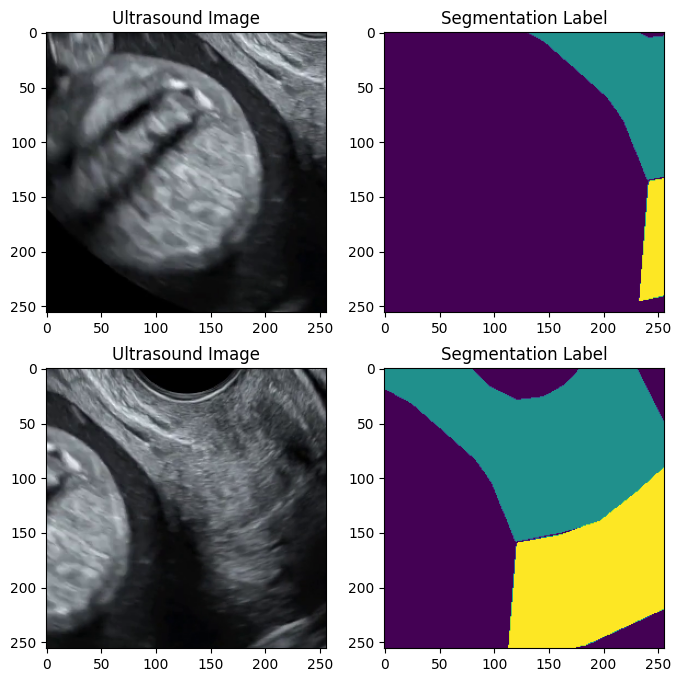

In [10]:
images, labels = next(iter(train_loader))

figure = plt.figure(figsize=(8, 8))

cols, rows = 2, 2
for i in range(rows):
    figure.add_subplot(rows, cols, 2*i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title('Ultrasound Image')

    figure.add_subplot(rows, cols, 2*i+2)
    plt.imshow(labels[i].permute(1, 2, 0))
    plt.title('Segmentation Label')

### Weighted Dice and Cross Entropy Loss

In [11]:
from scipy.ndimage import distance_transform_edt
import numpy as np

def multi_class_hausdorff_distance(preds, targets, num_classes=3, smooth=1e-6):
    """
    Compute the Multi-Class Hausdorff Distance for segmentation.
    
    Hausdorff distance measures how far two subsets of a metric space are from each other.
    For segmentation, it's useful to measure the similarity between segmentation boundaries.
    
    Args:
        preds: Predicted logits [B, C, H, W] (before softmax)
        targets: Ground truth labels [B, H, W] (integer class indices)
        num_classes: Number of segmentation classes.
        smooth: Smoothing factor to prevent division by zero.
        
    Returns:
        Average Hausdorff distance across all classes and batch samples.
    """
    
    # Convert predictions to class indices (argmax)
    preds = torch.softmax(preds, dim=1)
    pred_classes = torch.argmax(preds, dim=1).cpu().numpy()  # [B, H, W]
    
    # Convert targets to numpy
    targets = targets.cpu().numpy()  # [B, H, W]
    
    batch_size = pred_classes.shape[0]
    hausdorff_distances = []
    
    for batch_idx in range(batch_size):
        class_hausdorff = []
        
        for c in range(num_classes):
            # Create binary masks for current class
            pred_mask = (pred_classes[batch_idx] == c).astype(np.uint8)
            target_mask = (targets[batch_idx] == c).astype(np.uint8)
            
            # If either mask is empty (no pixels of this class), skip
            if not np.any(pred_mask) or not np.any(target_mask):
                continue
                
            # Compute distance transforms
            pred_distance = distance_transform_edt(1 - pred_mask)
            target_distance = distance_transform_edt(1 - target_mask)
            
            # Compute directed Hausdorff distances
            # (distance from prediction to target and vice versa)
            d_pt = np.max(pred_distance * target_mask)  # pred -> target
            d_tp = np.max(target_distance * pred_mask)  # target -> pred
            
            # Take the maximum of both directed distances
            hausdorff = max(d_pt, d_tp)
            class_hausdorff.append(hausdorff)
        
        if class_hausdorff:  # If we have valid measurements
            hausdorff_distances.append(np.mean(class_hausdorff))  # Average over classes
    
    # Average over batch samples
    return torch.tensor(np.mean(hausdorff_distances) if hausdorff_distances else 0.0, 
                       device=preds.device)

In [12]:
class CombinedLoss(nn.Module):
    """
    A combined loss function that includes Dice Loss, Cross-Entropy Loss, and Hausdorff Distance.
    This loss is useful for medical image segmentation tasks where boundary precision is important.
    """
    def __init__(self, num_classes=3, dice_weight=0.4, ce_weight=0.4, hausdorff_weight=0.2, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.num_classes = num_classes
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        self.hausdorff_weight = hausdorff_weight
        self.smooth = smooth
        self.ce_loss = nn.CrossEntropyLoss()
        
    def forward(self, preds, targets):
        """
        Compute the combined loss: Dice + Cross-Entropy + Hausdorff Distance.
        
        Args:
            preds: Predicted logits [B, C, H, W] (before softmax)
            targets: Ground truth labels [B, H, W] (integer class indices)
        
        Returns:
            Combined loss value
        """
        # Cross-Entropy Loss
        ce_loss = self.ce_loss(preds, targets)
        
        # Dice Loss
        preds_softmax = torch.softmax(preds, dim=1)
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2)
        
        dice_loss = 0
        for c in range(self.num_classes):
            pred_c = preds_softmax[:, c]
            target_c = targets_one_hot[:, c]
            
            intersection = (pred_c * target_c).sum(dim=(1, 2))
            union = pred_c.sum(dim=(1, 2)) + target_c.sum(dim=(1, 2))
            
            dice_coeff = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_loss += (1 - dice_coeff.mean())
        
        dice_loss = dice_loss / self.num_classes
        
        # Hausdorff Distance
        hausdorff_loss = multi_class_hausdorff_distance(preds, targets, self.num_classes, self.smooth)
        
        # Combine losses with weights
        total_loss = (self.dice_weight * dice_loss + 
                      self.ce_weight * ce_loss + 
                      self.hausdorff_weight * hausdorff_loss)
        
        return total_loss
    
    
class DiceCrossEntropyLoss(nn.Module):
    def __init__(self, num_classes=3, dice_weight=0.5, ce_weight=0.5, smooth=1e-6):
        super(DiceCrossEntropyLoss, self).__init__()
        self.num_classes = num_classes
        self.dice_weight = dice_weight  # Weight for Dice Loss
        self.ce_weight = ce_weight  # Weight for Cross-Entropy Loss
        self.smooth = smooth
        self.ce_loss = nn.CrossEntropyLoss()  # Standard Cross-Entropy Loss

    def forward(self, preds, targets):
        """
        Compute combined Dice + Cross-Entropy Loss.
        Args:
            preds: Predicted logits [B, C, H, W] (before softmax)
            targets: Ground truth labels [B, H, W] (integer class indices)
        Returns:
            Combined loss value
        """
        # Compute Cross-Entropy Loss
        ce_loss = self.ce_loss(preds, targets)

        # Convert logits to softmax probabilities for Dice Loss
        preds = torch.softmax(preds, dim=1)

        # One-hot encode targets to match preds shape [B, C, H, W]
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2)

        # Compute Dice Loss for each class
        dice_loss = 0
        for c in range(self.num_classes):
            pred_c = preds[:, c]  # Predictions for class c
            target_c = targets_one_hot[:, c]  # Ground truth for class c

            intersection = (pred_c * target_c).sum(dim=(1, 2))  # Sum over spatial dimensions
            union = pred_c.sum(dim=(1, 2)) + target_c.sum(dim=(1, 2))  # Sum of both areas

            dice_coeff = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_loss += (1 - dice_coeff.mean())  # Dice loss for class c

        dice_loss = dice_loss / self.num_classes  # Average over all classes

        # Weighted Sum of Dice and Cross-Entropy Loss
        total_loss = self.dice_weight * dice_loss + self.ce_weight * ce_loss

        return total_loss

In [13]:
def multi_class_dice_score(preds, targets, num_classes=3, smooth=1e-6):
    """
    Compute the Multi-Class Dice Score.

    Args:
        preds: Predicted logits [B, C, H, W] (before softmax)
        targets: Ground truth labels [B, H, W] (integer class indices)
        num_classes: Number of segmentation classes.
        smooth: Smoothing factor to prevent division by zero.

    Returns:
        Dice score averaged over all classes.
    """
    
    preds = torch.softmax(preds, dim=1)  # Convert logits to probabilities

    # Convert targets to one-hot format: [B, C, H, W]
    targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2)

    dice_scores = []
    
    for c in range(num_classes):
        pred_c = preds[:, c]  # Predictions for class c
        target_c = targets_one_hot[:, c]  # Ground truth for class c

        intersection = (pred_c * target_c).sum(dim=(1, 2))  # Sum over spatial dimensions
        union = pred_c.sum(dim=(1, 2)) + target_c.sum(dim=(1, 2))  # Sum of both areas

        dice_coeff = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice_coeff.mean())  # Average over batch

    return torch.mean(torch.stack(dice_scores))  # Average over all classes


In [14]:
loss_fn = CombinedLoss(num_classes=3,
                        dice_weight=0.33,
                        ce_weight=0.33,
                        hausdorff_weight=0.34,
                        smooth=1e-6)

# Freeze the backbone parameters
for param in model.encoder.parameters():
    param.requires_grad = False

# Train only the segmentation head initially
optimizer = torch.optim.Adam(model.segmentation_head.parameters(), lr=1e-3)

In [15]:
def test_model(model, test_loader, loss_fn, device, num_classes=3):
    model.eval()

    test_loss = 0
    test_dice = 0
    test_hausdorff = 0
    ce_loss = 0

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device).long()
            targets = targets.reshape((targets.shape[0], 256, 256))  # adjust if needed

            preds = model(images)
            loss = loss_fn(preds, targets)

            # Accumulate loss and dice
            test_loss += loss.item()
            ce_loss += nn.CrossEntropyLoss()(preds, targets).item()
            test_dice += multi_class_dice_score(preds, targets, num_classes=num_classes)

            # Compute and accumulate Hausdorff distance
            hd = multi_class_hausdorff_distance(preds, targets, num_classes=num_classes)
            test_hausdorff += hd.item()

            del images, targets, loss, preds
            torch.cuda.empty_cache()

    test_loss /= len(test_loader)
    ce_loss /= len(test_loader)
    test_dice /= len(test_loader)
    test_hausdorff /= len(test_loader)

    return ce_loss, test_dice, test_hausdorff


In [16]:

# def test_model(model, test_loader, loss_fn, device):

#     test_loss = 0
#     test_dice = 0

#     for images, targets in test_loader:
#         images, targets = images.to(device), targets.to(device).long()
#         targets = targets.reshape((targets.shape[0], 256, 256))

#         preds = model(images)
#         loss = loss_fn(preds, targets)

#         test_loss += loss.item()
#         test_dice += multi_class_dice_score(preds, targets, num_classes=3)

#     test_loss /= len(test_loader)
#     test_dice /= len(test_loader)

#     return test_loss, test_dice

In [17]:
# def train_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs=10):
    
#     train_losses = []
#     test_losses = []
#     train_dice_score = []
#     test_dice_score = []

#     for epoch in range(num_epochs):
#         print(
#             f'=====================================[Epoch: {epoch+1}/{n_epochs}]=========================================\n'
#             )

#         model.train()
#         train_loss = 0
#         train_dice = 0

#         for _, (images, targets) in enumerate(tqdm(train_loader)):
#             images, targets = images.to(device), targets.to(device).long()
#             targets = targets.reshape((targets.shape[0], 256, 256))

#             optimizer.zero_grad()
#             preds = model(images)  # Forward pass
            
#             loss = loss_fn(preds, targets)  # Compute loss
#             loss.backward()
#             optimizer.step()  # Update weights

#             train_loss += loss.item()
#             train_dice += multi_class_dice_score(preds, targets, num_classes=3)  # Compute Dice score

#         train_loss /= len(train_loader)
#         train_dice /= len(train_loader)

#         train_losses.append(train_loss)
#         train_dice_score.append(train_dice.item())

#         # Evaluation on test set
#         model.eval()
#         test_loss = 0
#         test_dice = 0

#         with torch.no_grad():
#             test_loss, test_dice = test_model(model, test_loader, loss_fn, device) 

#         test_losses.append(test_loss)
#         test_dice_score.append(test_dice.item())

#         # Print epoch summary
#         print(f"  Train Loss: {train_loss:.4f}\t\t Train Dice Score: {train_dice:.4f}")
#         print(f"  Test  Loss: {test_loss:.4f}\t\t Test  Dice Score: {test_dice:.4f}")
#         print("_"*100)

#     return model, train_losses, test_losses, train_dice_score, test_dice_score

In [18]:
def train_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs=10, num_classes=3):

    train_ce_losses = []
    test_ce_losses = []

    train_dice_score = []
    test_dice_score = []

    train_hausdorff_score = []
    test_hausdorff_score = []

    ce_loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        print(
            f'=====================================[Epoch: {epoch+1}/{num_epochs}]=========================================\n'
        )

        model.train()
        train_ce_loss = 0
        train_dice = 0
        train_hausdorff = 0

        for _, (images, targets) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            targets = targets.to(device).long()
            targets = targets.reshape((targets.shape[0], 256, 256))

            optimizer.zero_grad()
            preds = model(images)

            loss = loss_fn(preds, targets)
            loss.backward()
            optimizer.step()

            # compute individual losses and metrics (detach before storing)
            ce_loss = ce_loss_fn(preds.detach(), targets.detach())
            dice = multi_class_dice_score(preds.detach(), targets.detach(), num_classes=num_classes)
            hd = multi_class_hausdorff_distance(preds.detach(), targets.detach(), num_classes=num_classes)

            train_ce_loss += ce_loss.item()
            train_dice += dice
            train_hausdorff += hd.item()

            # Free up memory for current batch
            del images, targets, preds, loss, ce_loss, dice, hd
            torch.cuda.empty_cache()

        # Average over training batches
        train_ce_loss /= len(train_loader)
        train_dice /= len(train_loader)
        train_hausdorff /= len(train_loader)

        train_ce_losses.append(train_ce_loss)
        train_dice_score.append(train_dice)
        train_hausdorff_score.append(train_hausdorff)

        # Evaluation on test set
        torch.cuda.empty_cache()
        test_ce_loss, test_dice, test_hausdorff = test_model(model, test_loader, loss_fn, device, num_classes)

        test_ce_losses.append(test_ce_loss)
        test_dice_score.append(test_dice)
        test_hausdorff_score.append(test_hausdorff)

        # Epoch summary
        print(f"  Train Loss: {train_ce_loss:.4f} | Dice: {train_dice:.4f} | Hausdorff: {train_hausdorff:.4f}")
        print(f"  Test  Loss: {test_ce_loss:.4f} | Dice: {test_dice:.4f} | Hausdorff: {test_hausdorff:.4f}")
        print("_"*100)

        torch.cuda.empty_cache()

    return model, train_ce_losses, test_ce_losses, train_dice_score, test_dice_score, train_hausdorff_score, test_hausdorff_score


In [19]:
# Train the model
model, train_losses, test_losses, train_dice, test_dice, train_hausdorff, test_hausdorff = train_model(model, 
                                                                                                        train_loader, 
                                                                                                        test_loader,
                                                                                                        loss_fn,
                                                                                                        optimizer,
                                                                                                        n_epochs)


=====================================[Epoch: 1/100]=========================================



100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


  Train Loss: 1.2501 | Dice: 0.2810 | Hausdorff: 183.6148
  Test  Loss: 1.2062 | Dice: 0.2779 | Hausdorff: 186.6849
____________________________________________________________________________________________________
=====================================[Epoch: 2/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


  Train Loss: 1.0587 | Dice: 0.3112 | Hausdorff: 150.7432
  Test  Loss: 1.0345 | Dice: 0.3049 | Hausdorff: 129.7202
____________________________________________________________________________________________________
=====================================[Epoch: 3/100]=========================================



100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


  Train Loss: 0.8999 | Dice: 0.3565 | Hausdorff: 132.1329
  Test  Loss: 0.9836 | Dice: 0.3307 | Hausdorff: 154.4978
____________________________________________________________________________________________________
=====================================[Epoch: 4/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


  Train Loss: 0.8758 | Dice: 0.3935 | Hausdorff: 133.8500
  Test  Loss: 1.0956 | Dice: 0.3127 | Hausdorff: 168.1155
____________________________________________________________________________________________________
=====================================[Epoch: 5/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Train Loss: 0.8202 | Dice: 0.4247 | Hausdorff: 141.4595
  Test  Loss: 0.9369 | Dice: 0.3670 | Hausdorff: 155.1547
____________________________________________________________________________________________________
=====================================[Epoch: 6/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.7522 | Dice: 0.4571 | Hausdorff: 130.7280
  Test  Loss: 0.9627 | Dice: 0.3460 | Hausdorff: 162.9799
____________________________________________________________________________________________________
=====================================[Epoch: 7/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.7572 | Dice: 0.4560 | Hausdorff: 128.9948
  Test  Loss: 0.7473 | Dice: 0.4192 | Hausdorff: 127.9410
____________________________________________________________________________________________________
=====================================[Epoch: 8/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.6933 | Dice: 0.4805 | Hausdorff: 111.3106
  Test  Loss: 0.6791 | Dice: 0.4788 | Hausdorff: 112.7368
____________________________________________________________________________________________________
=====================================[Epoch: 9/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.7173 | Dice: 0.4762 | Hausdorff: 110.5152
  Test  Loss: 0.7031 | Dice: 0.4594 | Hausdorff: 110.8078
____________________________________________________________________________________________________
=====================================[Epoch: 10/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.6533 | Dice: 0.5123 | Hausdorff: 99.4169
  Test  Loss: 0.6080 | Dice: 0.4815 | Hausdorff: 103.9026
____________________________________________________________________________________________________
=====================================[Epoch: 11/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Train Loss: 0.6467 | Dice: 0.5018 | Hausdorff: 93.4873
  Test  Loss: 0.5798 | Dice: 0.5397 | Hausdorff: 87.7569
____________________________________________________________________________________________________
=====================================[Epoch: 12/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.6586 | Dice: 0.5087 | Hausdorff: 91.6262
  Test  Loss: 0.6173 | Dice: 0.5493 | Hausdorff: 94.7008
____________________________________________________________________________________________________
=====================================[Epoch: 13/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Train Loss: 0.6262 | Dice: 0.5288 | Hausdorff: 93.0363
  Test  Loss: 0.5881 | Dice: 0.5376 | Hausdorff: 90.9354
____________________________________________________________________________________________________
=====================================[Epoch: 14/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Train Loss: 0.6136 | Dice: 0.5414 | Hausdorff: 89.2099
  Test  Loss: 0.5053 | Dice: 0.5466 | Hausdorff: 87.8985
____________________________________________________________________________________________________
=====================================[Epoch: 15/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Train Loss: 0.6163 | Dice: 0.5361 | Hausdorff: 92.3963
  Test  Loss: 0.5948 | Dice: 0.5523 | Hausdorff: 91.4723
____________________________________________________________________________________________________
=====================================[Epoch: 16/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.5750 | Dice: 0.5529 | Hausdorff: 82.7396
  Test  Loss: 0.5119 | Dice: 0.5664 | Hausdorff: 97.0742
____________________________________________________________________________________________________
=====================================[Epoch: 17/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.5752 | Dice: 0.5732 | Hausdorff: 89.0127
  Test  Loss: 0.5787 | Dice: 0.5432 | Hausdorff: 107.7933
____________________________________________________________________________________________________
=====================================[Epoch: 18/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.5649 | Dice: 0.5661 | Hausdorff: 91.3194
  Test  Loss: 0.4600 | Dice: 0.5903 | Hausdorff: 90.2786
____________________________________________________________________________________________________
=====================================[Epoch: 19/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.5442 | Dice: 0.5765 | Hausdorff: 89.9366
  Test  Loss: 0.5090 | Dice: 0.5854 | Hausdorff: 86.7048
____________________________________________________________________________________________________
=====================================[Epoch: 20/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.5269 | Dice: 0.5863 | Hausdorff: 86.2454
  Test  Loss: 0.6014 | Dice: 0.5536 | Hausdorff: 109.2407
____________________________________________________________________________________________________
=====================================[Epoch: 21/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.5561 | Dice: 0.5642 | Hausdorff: 93.8320
  Test  Loss: 0.5268 | Dice: 0.5827 | Hausdorff: 82.5542
____________________________________________________________________________________________________
=====================================[Epoch: 22/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.5133 | Dice: 0.5905 | Hausdorff: 88.2578
  Test  Loss: 0.4399 | Dice: 0.5800 | Hausdorff: 91.9217
____________________________________________________________________________________________________
=====================================[Epoch: 23/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.4739 | Dice: 0.6060 | Hausdorff: 84.6810
  Test  Loss: 0.3954 | Dice: 0.6188 | Hausdorff: 85.1023
____________________________________________________________________________________________________
=====================================[Epoch: 24/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.5107 | Dice: 0.5987 | Hausdorff: 86.5453
  Test  Loss: 0.4432 | Dice: 0.6165 | Hausdorff: 88.5849
____________________________________________________________________________________________________
=====================================[Epoch: 25/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.4730 | Dice: 0.6142 | Hausdorff: 78.8305
  Test  Loss: 0.4050 | Dice: 0.6271 | Hausdorff: 72.3223
____________________________________________________________________________________________________
=====================================[Epoch: 26/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


  Train Loss: 0.4592 | Dice: 0.6217 | Hausdorff: 79.6737
  Test  Loss: 0.4628 | Dice: 0.6079 | Hausdorff: 82.7182
____________________________________________________________________________________________________
=====================================[Epoch: 27/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.4634 | Dice: 0.6260 | Hausdorff: 80.8913
  Test  Loss: 0.4183 | Dice: 0.6285 | Hausdorff: 77.1988
____________________________________________________________________________________________________
=====================================[Epoch: 28/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.4701 | Dice: 0.6279 | Hausdorff: 80.0863
  Test  Loss: 0.4182 | Dice: 0.6380 | Hausdorff: 88.2406
____________________________________________________________________________________________________
=====================================[Epoch: 29/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.4270 | Dice: 0.6263 | Hausdorff: 81.9439
  Test  Loss: 0.3978 | Dice: 0.6551 | Hausdorff: 79.6433
____________________________________________________________________________________________________
=====================================[Epoch: 30/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.4286 | Dice: 0.6562 | Hausdorff: 74.3250
  Test  Loss: 0.4003 | Dice: 0.6448 | Hausdorff: 83.7749
____________________________________________________________________________________________________
=====================================[Epoch: 31/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.4433 | Dice: 0.6409 | Hausdorff: 85.6812
  Test  Loss: 0.4049 | Dice: 0.6407 | Hausdorff: 89.8795
____________________________________________________________________________________________________
=====================================[Epoch: 32/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.4640 | Dice: 0.6498 | Hausdorff: 78.0027
  Test  Loss: 0.3769 | Dice: 0.6566 | Hausdorff: 75.4180
____________________________________________________________________________________________________
=====================================[Epoch: 33/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.4369 | Dice: 0.6633 | Hausdorff: 82.4548
  Test  Loss: 0.3650 | Dice: 0.6772 | Hausdorff: 67.6677
____________________________________________________________________________________________________
=====================================[Epoch: 34/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.4180 | Dice: 0.6672 | Hausdorff: 82.1754
  Test  Loss: 0.3879 | Dice: 0.7052 | Hausdorff: 80.3056
____________________________________________________________________________________________________
=====================================[Epoch: 35/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.4085 | Dice: 0.6938 | Hausdorff: 79.7455
  Test  Loss: 0.3860 | Dice: 0.7016 | Hausdorff: 94.8857
____________________________________________________________________________________________________
=====================================[Epoch: 36/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.3747 | Dice: 0.7292 | Hausdorff: 80.8274
  Test  Loss: 0.3513 | Dice: 0.7163 | Hausdorff: 77.4668
____________________________________________________________________________________________________
=====================================[Epoch: 37/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Train Loss: 0.3566 | Dice: 0.7424 | Hausdorff: 69.3627
  Test  Loss: 0.3134 | Dice: 0.7517 | Hausdorff: 65.2568
____________________________________________________________________________________________________
=====================================[Epoch: 38/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Train Loss: 0.3404 | Dice: 0.7545 | Hausdorff: 68.4417
  Test  Loss: 0.3010 | Dice: 0.7628 | Hausdorff: 69.2443
____________________________________________________________________________________________________
=====================================[Epoch: 39/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Train Loss: 0.3681 | Dice: 0.7658 | Hausdorff: 64.9286
  Test  Loss: 0.3180 | Dice: 0.7496 | Hausdorff: 57.1135
____________________________________________________________________________________________________
=====================================[Epoch: 40/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.3348 | Dice: 0.7532 | Hausdorff: 65.7719
  Test  Loss: 0.3070 | Dice: 0.7513 | Hausdorff: 74.1112
____________________________________________________________________________________________________
=====================================[Epoch: 41/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.3314 | Dice: 0.7586 | Hausdorff: 72.9951
  Test  Loss: 0.3054 | Dice: 0.7449 | Hausdorff: 75.7404
____________________________________________________________________________________________________
=====================================[Epoch: 42/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Train Loss: 0.3196 | Dice: 0.7784 | Hausdorff: 60.4946
  Test  Loss: 0.2566 | Dice: 0.8053 | Hausdorff: 60.2706
____________________________________________________________________________________________________
=====================================[Epoch: 43/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Train Loss: 0.3175 | Dice: 0.7714 | Hausdorff: 65.0603
  Test  Loss: 0.2649 | Dice: 0.7801 | Hausdorff: 51.4905
____________________________________________________________________________________________________
=====================================[Epoch: 44/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Train Loss: 0.2986 | Dice: 0.7928 | Hausdorff: 60.6560
  Test  Loss: 0.2945 | Dice: 0.7686 | Hausdorff: 64.1201
____________________________________________________________________________________________________
=====================================[Epoch: 45/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.3101 | Dice: 0.7805 | Hausdorff: 64.8516
  Test  Loss: 0.2603 | Dice: 0.7902 | Hausdorff: 59.5837
____________________________________________________________________________________________________
=====================================[Epoch: 46/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.3037 | Dice: 0.7786 | Hausdorff: 61.6031
  Test  Loss: 0.2642 | Dice: 0.7654 | Hausdorff: 59.2547
____________________________________________________________________________________________________
=====================================[Epoch: 47/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.3545 | Dice: 0.7606 | Hausdorff: 71.9901
  Test  Loss: 0.3313 | Dice: 0.7422 | Hausdorff: 73.7665
____________________________________________________________________________________________________
=====================================[Epoch: 48/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Train Loss: 0.3429 | Dice: 0.7706 | Hausdorff: 63.7813
  Test  Loss: 0.2851 | Dice: 0.7888 | Hausdorff: 62.2064
____________________________________________________________________________________________________
=====================================[Epoch: 49/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.2897 | Dice: 0.7798 | Hausdorff: 67.0541
  Test  Loss: 0.2524 | Dice: 0.7798 | Hausdorff: 52.9447
____________________________________________________________________________________________________
=====================================[Epoch: 50/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2945 | Dice: 0.7969 | Hausdorff: 58.8296
  Test  Loss: 0.2745 | Dice: 0.8070 | Hausdorff: 58.5594
____________________________________________________________________________________________________
=====================================[Epoch: 51/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.3024 | Dice: 0.8051 | Hausdorff: 57.2668
  Test  Loss: 0.2475 | Dice: 0.8011 | Hausdorff: 57.0810
____________________________________________________________________________________________________
=====================================[Epoch: 52/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2965 | Dice: 0.7738 | Hausdorff: 63.6929
  Test  Loss: 0.2644 | Dice: 0.7903 | Hausdorff: 59.6472
____________________________________________________________________________________________________
=====================================[Epoch: 53/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2743 | Dice: 0.8065 | Hausdorff: 57.0387
  Test  Loss: 0.2847 | Dice: 0.8122 | Hausdorff: 51.1296
____________________________________________________________________________________________________
=====================================[Epoch: 54/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2644 | Dice: 0.8116 | Hausdorff: 58.8730
  Test  Loss: 0.2510 | Dice: 0.8110 | Hausdorff: 53.7428
____________________________________________________________________________________________________
=====================================[Epoch: 55/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


  Train Loss: 0.2751 | Dice: 0.7944 | Hausdorff: 60.7552
  Test  Loss: 0.2542 | Dice: 0.8008 | Hausdorff: 51.0801
____________________________________________________________________________________________________
=====================================[Epoch: 56/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


  Train Loss: 0.2690 | Dice: 0.7997 | Hausdorff: 58.6200
  Test  Loss: 0.2052 | Dice: 0.8227 | Hausdorff: 51.0465
____________________________________________________________________________________________________
=====================================[Epoch: 57/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


  Train Loss: 0.2670 | Dice: 0.8148 | Hausdorff: 55.5124
  Test  Loss: 0.2222 | Dice: 0.8330 | Hausdorff: 47.6402
____________________________________________________________________________________________________
=====================================[Epoch: 58/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2515 | Dice: 0.8236 | Hausdorff: 54.6135
  Test  Loss: 0.2163 | Dice: 0.8147 | Hausdorff: 47.6466
____________________________________________________________________________________________________
=====================================[Epoch: 59/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2565 | Dice: 0.8215 | Hausdorff: 53.7627
  Test  Loss: 0.1847 | Dice: 0.8398 | Hausdorff: 46.3020
____________________________________________________________________________________________________
=====================================[Epoch: 60/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2537 | Dice: 0.8213 | Hausdorff: 52.3737
  Test  Loss: 0.2747 | Dice: 0.7975 | Hausdorff: 54.2695
____________________________________________________________________________________________________
=====================================[Epoch: 61/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2836 | Dice: 0.8050 | Hausdorff: 59.3337
  Test  Loss: 0.2509 | Dice: 0.8203 | Hausdorff: 57.8573
____________________________________________________________________________________________________
=====================================[Epoch: 62/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2624 | Dice: 0.8076 | Hausdorff: 57.4068
  Test  Loss: 0.2308 | Dice: 0.8245 | Hausdorff: 47.1294
____________________________________________________________________________________________________
=====================================[Epoch: 63/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2401 | Dice: 0.8265 | Hausdorff: 54.2351
  Test  Loss: 0.2660 | Dice: 0.7988 | Hausdorff: 54.1765
____________________________________________________________________________________________________
=====================================[Epoch: 64/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.2548 | Dice: 0.8209 | Hausdorff: 56.1367
  Test  Loss: 0.2149 | Dice: 0.8287 | Hausdorff: 47.5749
____________________________________________________________________________________________________
=====================================[Epoch: 65/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2451 | Dice: 0.8319 | Hausdorff: 53.5600
  Test  Loss: 0.2657 | Dice: 0.8034 | Hausdorff: 56.6129
____________________________________________________________________________________________________
=====================================[Epoch: 66/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


  Train Loss: 0.2327 | Dice: 0.8308 | Hausdorff: 53.0647
  Test  Loss: 0.2427 | Dice: 0.8188 | Hausdorff: 50.8048
____________________________________________________________________________________________________
=====================================[Epoch: 67/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


  Train Loss: 0.2281 | Dice: 0.8455 | Hausdorff: 51.0877
  Test  Loss: 0.2378 | Dice: 0.8183 | Hausdorff: 52.8086
____________________________________________________________________________________________________
=====================================[Epoch: 68/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2301 | Dice: 0.8323 | Hausdorff: 50.8656
  Test  Loss: 0.2648 | Dice: 0.8211 | Hausdorff: 46.4712
____________________________________________________________________________________________________
=====================================[Epoch: 69/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


  Train Loss: 0.2599 | Dice: 0.8168 | Hausdorff: 53.8125
  Test  Loss: 0.2868 | Dice: 0.7763 | Hausdorff: 48.6669
____________________________________________________________________________________________________
=====================================[Epoch: 70/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2894 | Dice: 0.7896 | Hausdorff: 60.2530
  Test  Loss: 0.2622 | Dice: 0.7922 | Hausdorff: 54.4449
____________________________________________________________________________________________________
=====================================[Epoch: 71/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


  Train Loss: 0.2698 | Dice: 0.8173 | Hausdorff: 54.3727
  Test  Loss: 0.2212 | Dice: 0.8315 | Hausdorff: 45.9882
____________________________________________________________________________________________________
=====================================[Epoch: 72/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


  Train Loss: 0.2468 | Dice: 0.8203 | Hausdorff: 52.4203
  Test  Loss: 0.2335 | Dice: 0.8101 | Hausdorff: 53.4892
____________________________________________________________________________________________________
=====================================[Epoch: 73/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2308 | Dice: 0.8358 | Hausdorff: 49.9338
  Test  Loss: 0.2522 | Dice: 0.8107 | Hausdorff: 57.8499
____________________________________________________________________________________________________
=====================================[Epoch: 74/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2385 | Dice: 0.8358 | Hausdorff: 49.7792
  Test  Loss: 0.2427 | Dice: 0.8157 | Hausdorff: 53.9231
____________________________________________________________________________________________________
=====================================[Epoch: 75/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2344 | Dice: 0.8319 | Hausdorff: 51.5832
  Test  Loss: 0.2115 | Dice: 0.8538 | Hausdorff: 44.7785
____________________________________________________________________________________________________
=====================================[Epoch: 76/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.2369 | Dice: 0.8267 | Hausdorff: 54.5703
  Test  Loss: 0.2429 | Dice: 0.8170 | Hausdorff: 50.1202
____________________________________________________________________________________________________
=====================================[Epoch: 77/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.2119 | Dice: 0.8505 | Hausdorff: 48.6871
  Test  Loss: 0.2181 | Dice: 0.8360 | Hausdorff: 47.1867
____________________________________________________________________________________________________
=====================================[Epoch: 78/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2389 | Dice: 0.8303 | Hausdorff: 50.4470
  Test  Loss: 0.2445 | Dice: 0.8115 | Hausdorff: 45.8037
____________________________________________________________________________________________________
=====================================[Epoch: 79/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2313 | Dice: 0.8282 | Hausdorff: 50.4589
  Test  Loss: 0.2239 | Dice: 0.8255 | Hausdorff: 48.3427
____________________________________________________________________________________________________
=====================================[Epoch: 80/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.2371 | Dice: 0.8350 | Hausdorff: 54.1741
  Test  Loss: 0.2334 | Dice: 0.8277 | Hausdorff: 54.6765
____________________________________________________________________________________________________
=====================================[Epoch: 81/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Train Loss: 0.2199 | Dice: 0.8488 | Hausdorff: 50.3236
  Test  Loss: 0.2202 | Dice: 0.8407 | Hausdorff: 51.1926
____________________________________________________________________________________________________
=====================================[Epoch: 82/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2211 | Dice: 0.8439 | Hausdorff: 48.7415
  Test  Loss: 0.2150 | Dice: 0.8395 | Hausdorff: 56.1802
____________________________________________________________________________________________________
=====================================[Epoch: 83/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2246 | Dice: 0.8378 | Hausdorff: 52.1102
  Test  Loss: 0.2130 | Dice: 0.8497 | Hausdorff: 44.2591
____________________________________________________________________________________________________
=====================================[Epoch: 84/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2029 | Dice: 0.8585 | Hausdorff: 46.8221
  Test  Loss: 0.2394 | Dice: 0.8391 | Hausdorff: 46.6134
____________________________________________________________________________________________________
=====================================[Epoch: 85/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


  Train Loss: 0.2312 | Dice: 0.8390 | Hausdorff: 49.4419
  Test  Loss: 0.1966 | Dice: 0.8477 | Hausdorff: 44.5495
____________________________________________________________________________________________________
=====================================[Epoch: 86/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2203 | Dice: 0.8358 | Hausdorff: 48.0064
  Test  Loss: 0.2066 | Dice: 0.8262 | Hausdorff: 45.8903
____________________________________________________________________________________________________
=====================================[Epoch: 87/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.2297 | Dice: 0.8412 | Hausdorff: 49.3841
  Test  Loss: 0.2328 | Dice: 0.8494 | Hausdorff: 43.0536
____________________________________________________________________________________________________
=====================================[Epoch: 88/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Train Loss: 0.2173 | Dice: 0.8498 | Hausdorff: 49.3419
  Test  Loss: 0.2198 | Dice: 0.8464 | Hausdorff: 46.3237
____________________________________________________________________________________________________
=====================================[Epoch: 89/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2158 | Dice: 0.8514 | Hausdorff: 47.2346
  Test  Loss: 0.2189 | Dice: 0.8342 | Hausdorff: 48.1404
____________________________________________________________________________________________________
=====================================[Epoch: 90/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Train Loss: 0.2182 | Dice: 0.8400 | Hausdorff: 49.0511
  Test  Loss: 0.2572 | Dice: 0.8124 | Hausdorff: 63.1366
____________________________________________________________________________________________________
=====================================[Epoch: 91/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


  Train Loss: 0.1984 | Dice: 0.8561 | Hausdorff: 45.3182
  Test  Loss: 0.2448 | Dice: 0.8346 | Hausdorff: 45.5588
____________________________________________________________________________________________________
=====================================[Epoch: 92/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


  Train Loss: 0.2316 | Dice: 0.8483 | Hausdorff: 50.7412
  Test  Loss: 0.1880 | Dice: 0.8456 | Hausdorff: 45.7012
____________________________________________________________________________________________________
=====================================[Epoch: 93/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


  Train Loss: 0.2239 | Dice: 0.8403 | Hausdorff: 48.5824
  Test  Loss: 0.2091 | Dice: 0.8383 | Hausdorff: 50.0004
____________________________________________________________________________________________________
=====================================[Epoch: 94/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


  Train Loss: 0.2251 | Dice: 0.8408 | Hausdorff: 49.9981
  Test  Loss: 0.2247 | Dice: 0.8377 | Hausdorff: 49.3414
____________________________________________________________________________________________________
=====================================[Epoch: 95/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


  Train Loss: 0.2277 | Dice: 0.8384 | Hausdorff: 51.5742
  Test  Loss: 0.2641 | Dice: 0.8249 | Hausdorff: 65.1664
____________________________________________________________________________________________________
=====================================[Epoch: 96/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


  Train Loss: 0.2067 | Dice: 0.8494 | Hausdorff: 48.5604
  Test  Loss: 0.2127 | Dice: 0.8233 | Hausdorff: 44.4961
____________________________________________________________________________________________________
=====================================[Epoch: 97/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


  Train Loss: 0.1966 | Dice: 0.8702 | Hausdorff: 45.6710
  Test  Loss: 0.2023 | Dice: 0.8557 | Hausdorff: 46.5601
____________________________________________________________________________________________________
=====================================[Epoch: 98/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


  Train Loss: 0.2111 | Dice: 0.8489 | Hausdorff: 47.2348
  Test  Loss: 0.2129 | Dice: 0.8567 | Hausdorff: 43.1685
____________________________________________________________________________________________________
=====================================[Epoch: 99/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


  Train Loss: 0.2125 | Dice: 0.8507 | Hausdorff: 51.9394
  Test  Loss: 0.2138 | Dice: 0.8504 | Hausdorff: 44.9574
____________________________________________________________________________________________________
=====================================[Epoch: 100/100]=========================================



100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


  Train Loss: 0.2023 | Dice: 0.8477 | Hausdorff: 49.3277
  Test  Loss: 0.2325 | Dice: 0.8452 | Hausdorff: 43.7487
____________________________________________________________________________________________________


In [28]:
for i in range(len(train_losses)):
    train_dice[i] = train_dice[i].detach().cpu().numpy()

for i in range(len(test_losses)):
    test_dice[i] = test_dice[i].detach().cpu().numpy()

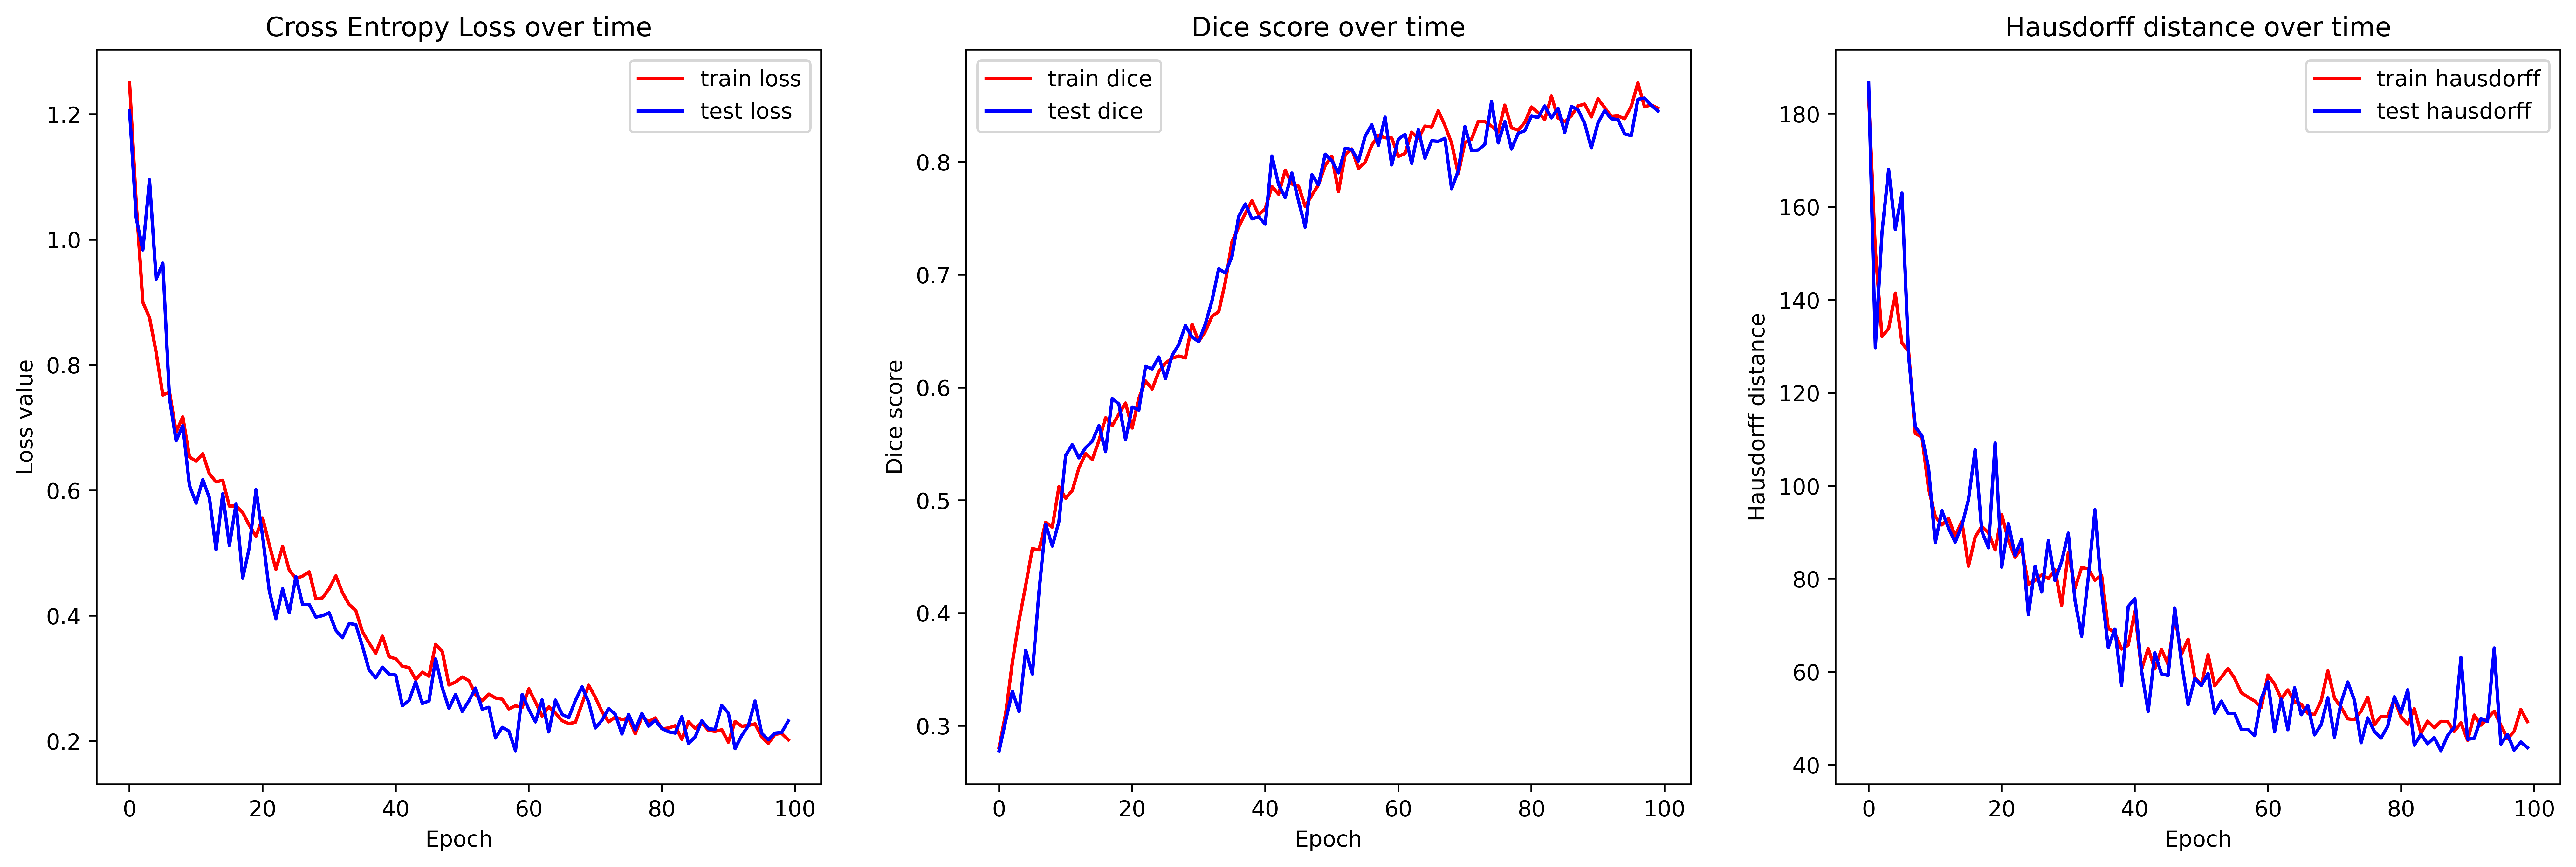

In [34]:
plt.figure(figsize=(20, 6), dpi=500)

plt.subplot(1, 3, 1)
plt.plot(train_losses, color='r', label='train loss')
plt.plot(test_losses, color='b', label='test loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.title('Cross Entropy Loss over time')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_dice, color='r', label='train dice')
plt.plot(test_dice, color='b', label='test dice')
plt.ylabel('Dice score')
plt.xlabel('Epoch')
plt.title("Dice score over time")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_hausdorff, color='r', label='train hausdorff')
plt.plot(test_hausdorff, color='b', label='test hausdorff')
plt.ylabel('Hausdorff distance')
plt.xlabel('Epoch')
plt.title("Hausdorff distance over time")
plt.legend()

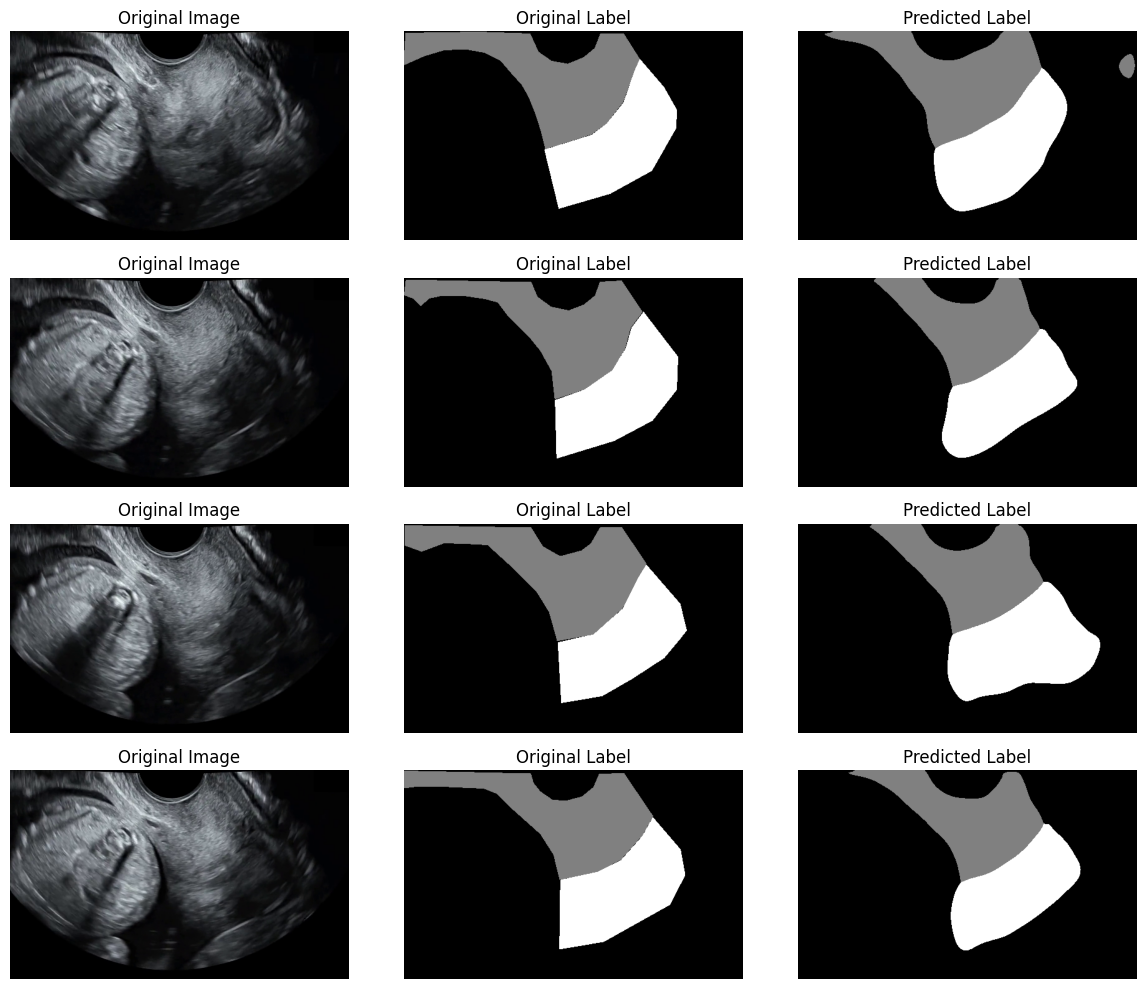

In [56]:
# Load original-size dataset for visualization (no crop)
# inference_transform = transforms.Compose([
#     transforms.ToTensor(),  # Only convert to tensor
# ])

# This assumes prepare_images returns PIL images
original_dataset = prepare_images(
    image_path='train/labeled_data/images',
    label_path='train/labeled_data/labels',
    transform_pipeline=None
)

# Get a few original (non-cropped) samples
figure = plt.figure(figsize=(12, 10))
cols, rows = 3, 4

for i in range(rows):
    image, label = original_dataset[i]  # original-size image and mask
    # Add batch dimension and send to model
    input_tensor = image.unsqueeze(0).to(device)  # shape: [1, C, H, W]
    with torch.no_grad():
        output = model(input_tensor)
        output = nn.functional.interpolate(output, size=label.shape[-2:], mode='bilinear', align_corners=False)
        pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()  # shape: H x W

    # Original image to numpy
    img_np = image.permute(1, 2, 0).cpu().numpy()  # CxHxW -> HxWxC
    label_np = label.squeeze().cpu().numpy()

    # Plot
    figure.add_subplot(rows, cols, 3*i + 1)
    plt.imshow(img_np)
    plt.title('Original Image')
    plt.axis('off')

    figure.add_subplot(rows, cols, 3*i + 2)
    plt.imshow(label_np, cmap='gray')
    plt.title('Original Label')
    plt.axis('off')

    figure.add_subplot(rows, cols, 3*i + 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Label')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the trained model on test data
model.eval()

print("Evaluating model on test data...")
test_ce_loss, dice, test_hausdorff = test_model(model, test_loader, loss_fn, device, num_classes=3)
print(f"Test Loss: {test_ce_loss:.4f}")
print(f"Test Dice Score: {dice:.4f}")
print(f"Test Hausdorff Distance: {test_hausdorff:.4f}")

Evaluating model on test data...


Test Loss: 0.2343
Test Dice Score: 0.8549
Test Hausdorff Distance: 41.4120


In [37]:
# save your network
torch.save(model.state_dict(), './byol_segmentation.pt')